# CNNs and transfer learning

## Introduction

In the past lab we have used the high-level API of PyTorch to implement an MLP. We have seen how shifted images produced significantly worse results, while to the human eye the examples are equally recognisable.

In this lab we will use convolutional layers to increase translation invariance of images. We will start with implementing a convolutional model to perform classification on MNIST and then we will load a pretrained model and use transfer learning on a new dataset of fish images.


## Objectives
- Learn to create a simple CNN model in PyTorch
- Use torch cuda device to improve training performance 
- Understand and perform transfer learning using pretrained models

## Getting started

We will first import all necessary modules:

In [107]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import numpy as np
import matplotlib.pyplot as plt

# Setting a seed value for reproducibility
torch.manual_seed(42)

## Convolutional neural network

In order to build a CNN we use Convolutional layers from PyTorch. In the case of images we will need 2D convolutions.

## Exercise 1

Implement the following model using PyTorch:

```
- convolutional 1 input channel (grayscale images), 6 output channels, kernel 5x5, stride 1x1
- rectified linear unit
- max pooling 2x2
- convolutional 6 input channels, 16 output channels, kernel 5x5, stride 1x1
- rectified linear unit
- max pooling 2x2
- flatten
- linear 120 output units
- rectified linear unit
- linear 84 output units
- rectified linear unit
- linear 10 output units
```

**Note:** we must provide the input dimension of the first linear layer. This will depend on how the convolutional and pooling layers have downsampled the input images. By carefully looking at the docs of PyTorch we can compute the output dimensions before the linear layer. The lazy way is: 
- put an arbitrary value
- print the shape of `x` after every operation
- run a forward on a single batch (you may obtain a single batch from a dataloader with `next(iter(my_dataloader))`
- check where it fails and correct the input dimension of that layer  

For now you may simply put your best guess and we will correct it after running the next cell.

In [108]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(1),
            nn.Linear(256, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )
        


    def forward(self, x):
        
        return self.net(x)
        

model = Net()
print(model)

x = torch.randn((1, 1, 28, 28))
model(x)

Net(
  (net): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)


tensor([[ 0.1013,  0.0457,  0.0239,  0.1012, -0.0988,  0.0393,  0.0412,  0.0291,
         -0.0294,  0.0125]], grad_fn=<AddmmBackward0>)

## Exercise 2
Create the datasets and data loaders for the MNIST dataset as done in the previous lab. Take the first batch and run a forward of the model correcting the input dimension of the first `Linear` layer.

In [109]:

transform_mnist = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5, )) # only one channel for grayscale image
    ]
)

# We use the same transform for the test and train set!
train_set = torchvision.datasets.MNIST(
    root="data/mnist",
    train=True,
    download=True,
    transform=transform_mnist
)

test_set = torchvision.datasets.MNIST(
    root="data/mnist",
    train=False,
    download=True,
    transform=transform_mnist
)

train_dataloader = torch.utils.data.DataLoader(
    train_set, batch_size=64, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    test_set, batch_size=64, shuffle=True)

inputs = train_dataloader
x = next(iter(train_dataloader))[0]
print(x.shape)



output = model(x)
print(x)

torch.Size([64, 1, 28, 28])
tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1.,

## Exercise 3

Train the model as done in the previous lab. Given that epochs take longer to compute with these models, we will print the average loss value every 1000 iterations. Write the train function so that every 1000 iterations it prints the average loss over these past 1000 iterations.

In [110]:
def train_model(model, dataloader, optimizer, criterion, n_epochs=1):
    model.train()

    for epoch in range(n_epochs):
        running_loss = 0.
        running_examples = 0
        for i, batch in enumerate(dataloader):
            
            optimizer.zero_grad()
            
            data_input, data_labels = batch

            # Get the output of the model
            outputs = model(data_input)

            # calculate the loss
            loss = criterion(outputs, data_labels)

            # Backwards propagation
            loss.backward()

            # Do the gradient descent step
            optimizer.step()

            if i % 1000 == 0:
                print(f"Current loss at iteration {i}: {loss}")
            #


def evaluate_model(model, dataloader):
    model.eval()

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            
            data_input = data[0]
            data_labels = data[1]

            # calculate outputs by running images through the network
            output = model(data_input)

            # the class with the highest energy is what we choose as prediction
            estimations = torch.tensor([torch.argmax(guess) for guess in output])

            correct += (estimations == data_labels).sum()
            total += len(data_labels)
            #

    accuracy = correct/total
    return accuracy

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 16

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

train_model(model, train_loader, optimizer, criterion, n_epochs=2)
accuracy = evaluate_model(model, test_loader)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')
    

Current loss at iteration 0: 2.2917559146881104
Current loss at iteration 1000: 1.5751246213912964
Current loss at iteration 2000: 0.1487967073917389
Current loss at iteration 3000: 0.1330450475215912
Current loss at iteration 0: 0.013943592086434364
Current loss at iteration 1000: 0.00934456754475832
Current loss at iteration 2000: 0.061733685433864594
Current loss at iteration 3000: 0.11968077719211578
Accuracy of the network on the test images: 97.2%


We notice that the change in architecture improves the accuracy obtained on the test set. However we also notice the training and testing takes longer. Convolutions are operations that can benefit significantly from GPU processing.

We will now learn how to move the data and operations to the GPU device to take advantage of its benefits.

The first thing to do is to obtain the GPU `device` if available, falling back to the CPU if the GPU is not available. This can be done with the following statement:

```
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
```

Then we may move the `nn.Module` that we want run in GPU:

```
model.to(device)
```

We must also move the data `inputs` and `labels` to the GPU before using them.

```
inputs, labels = inputs.to(device), labels.to(device)
```

**Note:** in Google's Collaboratory environment we may request running the Python kernel on a GPU. To do so go to the Menu > Runtime > Change runtime type. Only use this feature when needed to avoid using unnecessary ressources.

## Exercise 4

Re-train the model, this time on GPU.

In [111]:
def train_model(model, dataloader, optimizer, criterion, n_epochs=1, log_every=1000, device='cpu'):
    
    model.train()
    model.to(device)

    for epoch in range(n_epochs):
        for i, batch in enumerate(dataloader):
            
            optimizer.zero_grad()
            data_input, data_labels = batch

            # use the gpu, if possible
            data_input = data_input.to(device)
            data_labels = data_labels.to(device)

            # Get the output of the model
            outputs = model(data_input)

            # calculate the loss
            loss = criterion(outputs, data_labels)

            # Backwards propagation
            loss.backward()

            # Do the gradient descent step
            optimizer.step()

            if i % log_every == 0:
                print(f"Current loss at iteration {i}: {loss}")
            #
    #

def evaluate_model(model, dataloader, device='cpu'):
    
    model.eval()
    model.to(device)

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            
            data_input, data_labels = data
            data_input, data_labels = data_input.to(device), data_labels.to(device)

            # calculate outputs by running images through the network
            output = model(data_input.to(device))

            # the class with the highest energy is what we choose as prediction
            estimations = torch.tensor([torch.argmax(guess) for guess in output], device=device)

            correct += (estimations == data_labels).sum()
            total += len(data_labels)
            #

    accuracy = correct/total
    return accuracy

    #

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 16

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the 10000 test images: {accuracy:.1%}')


Using device: cuda:0
Current loss at iteration 0: 2.338569164276123
Current loss at iteration 1000: 0.604841947555542
Current loss at iteration 2000: 0.15486133098602295
Current loss at iteration 3000: 0.1181611642241478
Current loss at iteration 0: 0.005797253455966711
Current loss at iteration 1000: 0.18703213334083557
Current loss at iteration 2000: 0.05661757290363312
Current loss at iteration 3000: 0.13630083203315735
Accuracy of the network on the 10000 test images: 97.2%


In this case the speed-up may not be too noticeable because the model is small. But we can now increase the number of convolutional filters without having a large impact on training time.

## Exercise 5

Try changing the number of filters of the first convolution to 16 and the next to 36.

In [112]:
class Net(nn.Module):
    def __init__(self):
        
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 36, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(1),
            nn.Linear(36*16, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

Current loss at iteration 0: 2.292780637741089
Current loss at iteration 1000: 0.2898399531841278
Current loss at iteration 2000: 0.14437273144721985
Current loss at iteration 3000: 0.07659664750099182
Current loss at iteration 0: 0.009196448139846325
Current loss at iteration 1000: 0.03166266903281212
Current loss at iteration 2000: 0.04465964809060097
Current loss at iteration 3000: 0.07470932602882385
Accuracy of the network on the test images: 97.2%


We will now test whether using CNN allows us to improve performance on the test set of shifted images. 

## Exercise 6
Create a new `test_shifted_set` and `test_shifted_loader` where images are shifted 3 pixels to the right and plot the first image. Use the transforms API of PyTorch (e.g. `transforms.Lambda`).

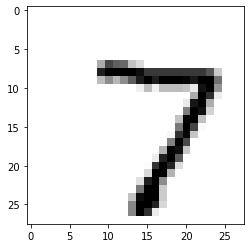

In [113]:
n_shifts = 3

transform = transforms.Compose(
    [
     
     transforms.ToTensor(),
     transforms.Lambda(lambda im : torch.roll(im, n_shifts)) # use lambda for defining custom function acting on input
     
    ])

test_shifted_set = torchvision.datasets.MNIST('data/mnist', download=True, train=False, transform=transform)

# The transformation defined by the lambda functin above is used
test_shifted_loader = torch.utils.data.DataLoader(test_shifted_set, batch_size=batch_size)

plt.imshow(test_shifted_set[0][0][0], cmap='gray_r')
plt.show()

## Exercise 7

Test the performance of the previously trained model on the new test set.

In [114]:

accuracy = evaluate_model(model, test_shifted_loader, device=device)


print(f'Accuracy of the network on the test images: {accuracy:.1%}')

Accuracy of the network on the test images: 62.9%


## [Optional] Exercise 8

Compare the performance of an MLP vs CNN for shifts of increasing number of pixels.

In [115]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

def train_model_mlp(model, dataloader, optimizer, criterion, n_epochs=1, log_every=1000, device='cpu'):
    for epoch in range(n_epochs):
        for i, (mini_batch, targets) in enumerate(dataloader):
            # Zero the gradients
            optimizer.zero_grad()

            # Get the output of the model
            outputs = model(mini_batch)

            # calculate the loss
            loss = criterion(outputs, targets)

            # Backwards propagation
            loss.backward()

            # Do the gradient descent step
            optimizer.step()

            if i % log_every == 0:
                print(f"Current loss at iteration {i}: {loss}")

    return model

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 36, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(1),
            nn.Linear(36*16, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        return self.net(x)

def train_model_cnn(model, dataloader, optimizer, criterion, n_epochs=1, log_every=1000, device='cpu'):
    model.train()
    model.to(device)

    for epoch in range(n_epochs):
        for i, batch in enumerate(dataloader):
            optimizer.zero_grad()
            data_input, data_labels = batch
            data_input.to(device)
            data_labels.to(device)

            # Get the output of the model
            outputs = model(data_input)

            # calculate the loss
            loss = criterion(outputs, data_labels)

            # Backwards propagation
            loss.backward()

            # Do the gradient descent step
            optimizer.step()

            if i % log_every == 0:
                print(f"Current loss at iteration {i}: {loss}")
    
    return model


In [116]:
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_epochs = 3

print("Training MLP...")
mlp = MLP()
optimizer = optim.SGD(mlp.parameters(), lr=0.001, momentum=0.9)
mlp = train_model_mlp(mlp, train_loader, optimizer, criterion, n_epochs=n_epochs)

print("\n Training CNN...")
cnn = Net()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)
cnn = train_model_cnn(cnn, train_loader, optimizer, criterion, n_epochs=n_epochs)

print("\n Training Complete")

Training MLP...
Current loss at iteration 0: 2.3669052124023438
Current loss at iteration 1000: 1.2970317602157593
Current loss at iteration 2000: 0.4656926095485687
Current loss at iteration 3000: 0.4612080454826355
Current loss at iteration 0: 0.28297168016433716
Current loss at iteration 1000: 0.5013214349746704
Current loss at iteration 2000: 0.17874515056610107
Current loss at iteration 3000: 0.266123503446579
Current loss at iteration 0: 0.13142123818397522
Current loss at iteration 1000: 0.37255236506462097
Current loss at iteration 2000: 0.1401311457157135
Current loss at iteration 3000: 0.22836241126060486

 Training CNN...
Current loss at iteration 0: 2.2963709831237793
Current loss at iteration 1000: 0.3515278398990631
Current loss at iteration 2000: 0.1321527361869812
Current loss at iteration 3000: 0.09110785275697708
Current loss at iteration 0: 0.009284956380724907
Current loss at iteration 1000: 0.02685856632888317
Current loss at iteration 2000: 0.08184146881103516
Cur

In [117]:
n_shifts = [0, 2, 5, 10]

# Comparing the performance over various shifts
for shift in n_shifts:
    transform = transforms.Compose(
        [
        transforms.ToTensor(),
        transforms.Lambda(lambda im : torch.roll(im, shift))
        ])
    test_shifted_set = torchvision.datasets.MNIST('data/mnist', download=True, train=False, transform=transform)
    test_shifted_loader = torch.utils.data.DataLoader(test_shifted_set, batch_size=batch_size)

    print(f"Shifted Image by {shift} pixels: ")

    accuracy = evaluate_model(mlp, test_shifted_loader, device=device)
    print(f'Accuracy of the MLP on the test images: {accuracy:.1%}')

    accuracy = evaluate_model(cnn, test_shifted_loader, device=device)
    print(f'Accuracy of the network on the test images: {accuracy:.1%}')

    print("")

# The rapidly decreasing performance after the 5 pixel shift makes sense, 
# given the dimension of the input image: the letters are basically split 
# in half from that point on 


Shifted Image by 0 pixels: 
Accuracy of the MLP on the test images: 77.6%
Accuracy of the network on the test images: 91.0%

Shifted Image by 2 pixels: 
Accuracy of the MLP on the test images: 59.2%
Accuracy of the network on the test images: 85.8%

Shifted Image by 5 pixels: 
Accuracy of the MLP on the test images: 12.0%
Accuracy of the network on the test images: 29.4%

Shifted Image by 10 pixels: 
Accuracy of the MLP on the test images: 14.5%
Accuracy of the network on the test images: 10.3%



## [Optional] Exercise 9

Propose a solution (and optionally implement it) to make the models even more robust to shifts?


- data augmentation: Training data with randomly shifted images

- Centering the input around its center of mass in the image, in order to get a more shift robust representation of the input

In [118]:
# Freeing RAM for running the notebook in one go 

del model
del mlp 
del cnn

# Transfer learning

It is quite rare that we implement new models from scratch, specially when our target dataset is small.

We will often perform what is known as transfer learning: **start from well-established models pre-trained on large quantities of similar data**. For example, for natural image related tasks we will often start from a `ResNet` or `MobileNet`, whose weights have been trained on a classification task on ImageNet.

The model chosen to base our work on is often referred to as the **backbone**.

Depending on the task the pre-trained model may not be directly usable. Even when performing a classification task, the classes may not be the same, even the number of classes may vary. Therefore, for sure the output layer of the model may need to be modified (and re-trained).

PyTorch provides pre-trained models from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) and from [PyTorch Hub](https://pytorch.org/hub/). Throughout this lab we will use the PyTorch Hub way.

For instance to download a [ResNet-18 model](https://pytorch.org/hub/pytorch_vision_resnet/) we would do:

```
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
```

To practice the methodology of transfer learning, we will use a small dataset provided by [here](https://homepages.inf.ed.ac.uk/rbf/fish4knowledge/GROUNDTRUTH/RECOG/)

We will do the following steps:
1. Download the data and untar it
2. Create a dataset object using [torchvision.datasets.ImageFolder](https://pytorch.org/vision/stable/datasets.html?highlight=imagefolder#torchvision.datasets.ImageFolder)
3. Split the dataset into train and test using [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
4. Train several models on the data
    1. A simple custom made CNN model
    2. A ResNet-18 without pretrained weights
    3. A ResNet-18 with pretrained weights training only the last layer

When splitting the data into train and test we will do a 80% / 20% ratio per each class (stratified). <!--We notice in the dataset that consecutive images seem to be extracted often from the same video segment, therefore we will split data in consecutive chunks instead of shuffling it (random split).-->

## Exercise 10
Download the data and untar it. Using `wget` (run with the `-nc` flag to avoid redownloading unnecessarily multiple times) and `tar`. Bash commands in Colab and Jupyter must be preceded by a `!`.

In [119]:

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)
FISH_FOLDER = 'fish_folder'
FISH_URL = "https://homepages.inf.ed.ac.uk/rbf/fish4knowledge/GROUNDTRUTH/RECOG/Archive/fishRecognition_GT.tar"

# Downloading the fish pictures, untarring them, and removing the masks saved
# with the dataset
!wget -nc $FISH_URL 
!mkdir -p $FISH_FOLDER
!tar -xvf fishRecognition_GT.tar -C $FISH_FOLDER --strip-components 1
!rm -rf ./$FISH_FOLDER/mask*
!ls ./$FISH_FOLDER



Streaming output truncated to the last 5000 lines.
mask_image/mask_04/mask_004604757458_09078.png
mask_image/mask_04/mask_004604757458_10222.png
mask_image/mask_04/mask_004604757458_11090.png
mask_image/mask_04/mask_004604757458_15432.png
mask_image/mask_04/mask_004604837458_09077.png
mask_image/mask_04/mask_004604857458_17760.png
mask_image/mask_04/mask_004604887458_11726.png
mask_image/mask_04/mask_004604887458_17623.png
mask_image/mask_04/mask_004604887458_21280.png
mask_image/mask_04/mask_004604897458_23260.png
mask_image/mask_04/mask_004604957458_13532.png
mask_image/mask_04/mask_004604957458_15905.png
mask_image/mask_04/mask_004604977458_08967.png
mask_image/mask_04/mask_004604977458_09619.png
mask_image/mask_04/mask_004604977458_13357.png
mask_image/mask_04/mask_004604977458_16125.png
mask_image/mask_04/mask_004604997458_20199.png
mask_image/mask_04/mask_004604997458_23256.png
mask_image/mask_04/mask_004605017458_21076.png
mask_image/mask_04/mask_004605127458_13639.png
mask_imag

## Exercise 11
Create a `torchvision.datasets.ImageFolder` for the full fish recognition dataset and plot the first example.

23


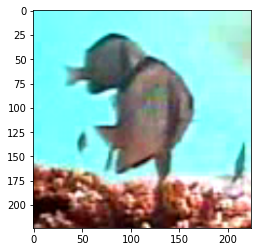

In [120]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    ]
)


batch_size = 16

full_set = torchvision.datasets.ImageFolder(root=FISH_FOLDER, transform=transform)
full_set_loader = torch.utils.data.DataLoader(full_set, batch_size=batch_size)

first_fish = next(iter(full_set_loader))[0][0] # data as [[(3, H, W), LABEL], ]
first_fish = torch.permute(first_fish, (1, 2, 0)) # imshow takes (H, W, 3), 
plt.imshow(first_fish)



full_set.classes = [
    'Dascyllus reticulatus',
    'Plectroglyphidodon dickii',
    'Chromis chrysura',
    'Amphiprion clarkii',
    'Chaetodon lunulatus',
    'Chaetodon trifascialis',
    'Myripristis kuntee',
    'Acanthurus nigrofuscus',
    'Hemigymnus fasciatus',
    'Neoniphon sammara',
    'Abudefduf vaigiensis',
    'Canthigaster valentini',
    'Pomacentrus moluccensis',
    'Zebrasoma scopas',
    'Hemigymnus melapterus',
    'Lutjanus fulvus',
    'Scolopsis bilineata',
    'Scaridae',
    'Pempheris vanicolensis',
    'Zanclus cornutus',
    'Neoglyphidodon nigroris',
    'Balistapus undulatus',
    'Siganus fuscescens'  	
]

print(len(full_set.classes))

## Exercise 12

Using the [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) and the labels from `full_set.targets` perform a stratified random split.

Then create the two new datasets `train_set` and `test_set` using [`torch.utils.data.Subset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset)

In [121]:
from sklearn.model_selection import train_test_split
import random

labels = list(full_set.targets)
indices = np.arange(len(labels))

# Random splits


# For saving memory consumption, the split is performed on the indices and not 
# on the images itself
x_train_ind, x_test_ind, y_train_ind, y_test_ind = train_test_split(indices, labels, stratify=labels, train_size=0.8)
train_set = torch.utils.data.Subset(full_set, x_train_ind)
test_set = torch.utils.data.Subset(full_set, x_test_ind)



## Exercise 13

Compute on a batch of 500 random samples the mean and std deviation for each of the RGB channels. Set these in the `Normalize` transform of the full dataset of the previous cells in order to obtain a normalized version of the dataset.

In [122]:
loader = torch.utils.data.DataLoader(train_set, batch_size=500, shuffle=True, num_workers=1)



rgb_means = {'r': [], 'g': [], 'b': []}
rgb_stds = {'r': [], 'g': [], 'b': []}

first_batch = next(iter(loader))

for im in first_batch:
    for i in im:
        r_mean, g_mean, b_mean = torch.mean(i, dtype=torch.float, dim = [1,2]) # iterating over columns and rows
        r_std, g_std, b_std = torch.std(i, dim = [1,2]) # iterating over columns and rows

        rgb_means['r'].append(r_mean)
        rgb_means['g'].append(g_mean)
        rgb_means['b'].append(b_mean)

        rgb_stds['r'].append(r_std)
        rgb_stds['g'].append(g_std)
        rgb_stds['b'].append(b_std)
    break

for k, val in rgb_means.items():
    print(f"Mean of {k}: {np.mean(val)}")

for k, val in rgb_stds.items():
    print(f"STD of {k}: {np.mean(val)}")



Mean of r: 0.4777310788631439
Mean of g: 0.6107195019721985
Mean of b: 0.5830934047698975
STD of r: 0.20284976065158844
STD of g: 0.2564069628715515
STD of b: 0.25388479232788086


## Exercise 14

Before tackling transfer learning with an existing model, we will revisit the simple CNN and training procedure we built for MNIST earlier in this lab and make a few modifications.

1. We must first adapt the input to 3 channels (RGB)
2. Adapt the output of the network to the number of classes in our task
3. Increase the number of convolutional layers to 3 (we have larger images) with number of filters `[6, 16, 32]`
4. Adapt the number of inputs of the first fully connected layer
5. Increase the batch size to `64` to improve training time

In [123]:
class Net(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 36, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(1),
            nn.Linear(36*16*6*6, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, n_classes)
        )

    def forward(self, x):
        return self.net(x)

def train_model(model, dataloader, optimizer, criterion, n_epochs=1, log_every=200, device='cpu'):
    model.train()
    model.to(device)

    for epoch in range(n_epochs):
        for i, batch in enumerate(dataloader):
            optimizer.zero_grad()
            data_input, data_labels = batch
            data_input = data_input.to(device)
            data_labels = data_labels.to(device)

            # Get the output of the model
            outputs = model(data_input)

            # calculate the loss
            loss = criterion(outputs, data_labels)

            # Backwards propagation
            loss.backward()

            # Do the gradient descent step
            optimizer.step()

            if i % log_every == 0:
                print(f"Current loss at iteration {i}: {loss}")
    
    return model

def evaluate_model(model, dataloader, device='cpu'):
    model.eval()
    model.to(device)

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            
            data_input, data_labels = data
            data_input = data_input.to(device)
            data_labels = data_labels.to(device)

            # calculate outputs by running images through the network
            output = model(data_input)

            # the class with the highest energy is what we choose as prediction
            estimations = torch.tensor([torch.argmax(guess) for guess in output], device=device)

            correct += (estimations == data_labels).sum()
            total += len(data_labels)
            #

    accuracy = correct/total
    return accuracy

# We use the values obtained in the last exercise here
mean = [rgb_means['r'], rgb_means['g'], rgb_means['b']]
std = [rgb_stds['r'], rgb_stds['g'], rgb_stds['b']]

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
    ]
)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Net(len(full_set.classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_model(model, train_loader, optimizer, criterion, n_epochs=1, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

Current loss at iteration 0: 3.2017509937286377
Current loss at iteration 50: 2.9693667888641357
Current loss at iteration 100: 1.9490199089050293
Current loss at iteration 150: 1.4744899272918701
Current loss at iteration 200: 1.2851210832595825
Current loss at iteration 250: 1.2267650365829468
Current loss at iteration 300: 1.2382936477661133
Accuracy of the network on the test images: 70.4%


We will now create two utility function to help us visualize the outputs of an image classification model.

## Exercise 15

Create a function that takes an image, a model and list of classes and plots the image and a horizontal bar plot (using [`plt.barh`](https://matplotlib.org/stable/gallery/lines_bars_and_markers/barh.html)) showing the probabilities assigned to the top 10 predicted classes (using [`torch.topk`](https://pytorch.org/docs/stable/generated/torch.topk.html?highlight=topk#torch.topk)). Test it on the first image of the test set and using previous trained model.

**Note**: think of bringing back to the cpu and converting to numpy `my_np_array = my_torch_tensor.cpu().numpy()` torch tensors that are in the GPU.

<ipython-input-124-67618d0539d9>:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out) # For getting probabilities a softmax is applied
<ipython-input-124-67618d0539d9>:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 2) # (columns, rows, current_subplot)


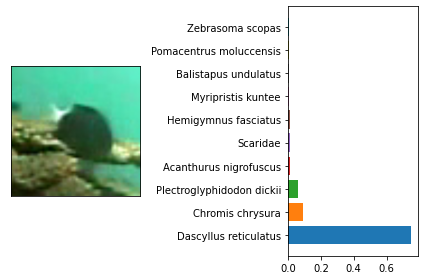

In [124]:
def viz_image(image, model, classes, top=10, device='cpu'):
    assert image.ndim == 3, "Images are expected to have 3 dimensions: channels x height x width"
    was_training = model.training
    model.eval()
    model = model.to(device)

    with torch.no_grad():
        
        plt.subplot(1, 2, 1) # (columns, rows, current_subplot)
        image_perm = torch.permute(image, (1, 2, 0)) # imshow takes (H, W, 3), 
        plt.imshow(image_perm)
        plt.xticks([])
        plt.yticks([])

        image = torch.unsqueeze(image, 0) # the network expects an array of images (N, C, H, W)
        image = image.to(device)
        out = model(image)
        out = F.softmax(out) # For getting probabilities a softmax is applied
        probabilities, prob_indices = torch.topk(out, top)

        for p, i in zip(probabilities.squeeze(), prob_indices.squeeze()):
            class_of_image = full_set.classes[i]

            plt.subplot(1, 2, 2) # (columns, rows, current_subplot)
            plt.barh(class_of_image, p.cpu())

        
        

    plt.tight_layout()
    model.train(was_training)

image, label = test_set[0]
viz_image(image, model, full_set.classes, device=device)

## Exercise 16

Next we will visualize a batch of images and the class predicted by the model with it's probability in parentheses as their `xlabel`.
The function will also return the probabilites of all classes predicted for each image (tensor of `torch.float` with shape `(N, 1000)` where `N` is the number of images in the batch) and the class predicted by the model for each image (tensor of `torch.long` with shape `(N)`).

**Hint**: for create a grid of images consider the following snippet

```
fig = plt.figure(figsize=(10, 10))
for i, image in enumerate(images):
    ax = fig.add_subplot(n_rows, n_cols, i+1)

    # some code to normalize each image

    ax.imshow(...
```

**Note**: Normalize the pixels of each image between 0 and 1 before plotting it to obtain natural colors. Remember we need to do this, because each image was previously normalized to mean 0 and stddev 1 in order to be fed in the expected way by the model.

tensor([2, 0, 0, 2, 8, 0, 1, 3, 3, 2, 1, 0, 2, 0, 4, 0])


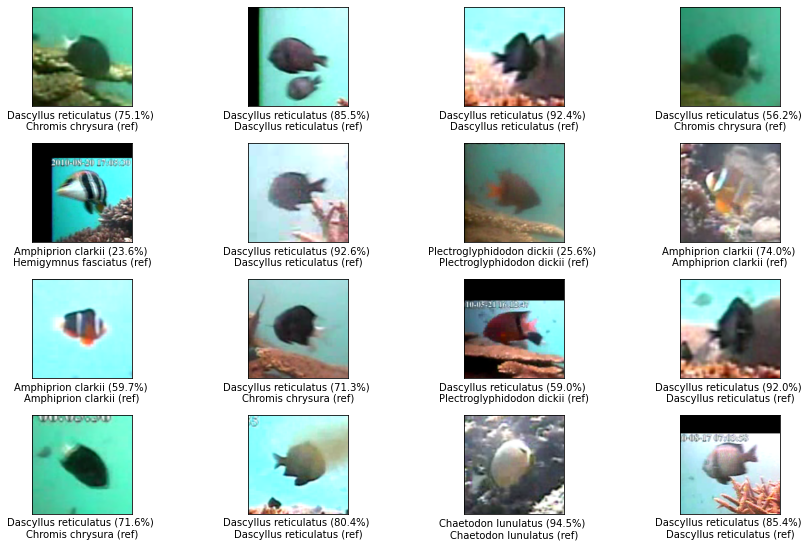

In [125]:
def viz_image_batch(images, model, classes, top=5, device='cpu', labels=None):
    assert images.ndim == 4, "Images are expected to have 4 dimensions: batch index x channels x height x width"
    model = model.to(device)

    was_training = model.training
    model.eval()

    # The first channel gets the number of images
    image_number = images.size()[0]

    class_probabilities = torch.zeros((image_number, 1), dtype=torch.float)
    class_predicted = torch.zeros((image_number, 1000), dtype=torch.long) # Do not know why 1000 as rows


    with torch.no_grad():
        
        n_rows = image_number
        n_cols = 4
            
        fig = plt.figure(figsize=(12, 30))
        for i, image in enumerate(images):
            ax = fig.add_subplot(n_rows, n_cols, i+1)

            image_input = torch.unsqueeze(image, 0) # the network expects an array of images (N, C, H, W)
            image_input = image_input.to(device)
            out = model(image_input)
            out = F.softmax(out, dim=-1) # For getting probabilities from activations
            probability, index = torch.topk(out, 1) # getting the top prediction

            image_perm = torch.permute(image, (1, 2, 0)) # imshow takes (H, W, 3)
            class_of_image = classes[index]

            ax.imshow(image_perm)
            
            ground_truth = classes[labels[i]] if labels is not None else 'None'
            ax.set_xlabel(f"{class_of_image} ({probability.item():.1%}) \n{ground_truth} (ref)")
            ax.set_xticks([]) # Removing the backticks from the image graph
            ax.set_yticks([])


            class_probabilities[i] = probability
            class_predicted[i] = index

        

    plt.tight_layout()
    model.train(was_training)
    
    return (class_probabilities, class_predicted)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, pin_memory=True, num_workers=2)

images, labels = next(iter(test_loader))
print(labels)
probs, preds = viz_image_batch(images, model, full_set.classes, labels=labels, device=device)


# ResNet model

ResNets are a family of models that have been popularized by their performance in image classification tasks. We will start by downloading a [ResNet18 model](https://pytorch.org/vision/stable/models.html#torchvision.models.resnet18) (a ResNet model composed of 18 layers). Other variants exist with varying number of layers: `resnet34`, `resnet50`, `resnet101`, `resnet152`.

When using an existing model with our particular task, we must first ensure that the inputs of the model are correctly matched.
- The images must have a size compatible with the model

In the case of resnet18, it expects images of size 224x224. In Exercise 11 we had created our datasets for the underwater images in a way that images were scaled (and cropped when necessary) to this size. 

```
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    ...
    ]
```
- The images must have been normalised in an equal (or similar) way

In [torchvision documentation](https://pytorch.org/vision/stable/models.html#:~:text=All%20pre%2Dtrained,0.229%2C%200.224%2C%200.225%5D) we find that the models expect images to be normalized with zero mean and standard deviation of 1.  For the natural images in ImageNet, this corresponds to the following transform:

```
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ]
```

However in this lab we have recomputed the statistics of a subsample of our data, since underwater images may have significantly different statistics. 

- The output of the model may need to be modified to match our class set

At first we will not change the output, however the following exercises will require changing the final layer of the model to adapt to our own class set.

## Exercise 17
We will start by downloading a pre-trained `resnet18` and visualizing how it classifies our own images into the ImageNet classes.
**Note**: in order to show the class labels with which it was trained, we could download ImageNet using [`torchvision.datasets.ImageNet`](https://pytorch.org/vision/stable/datasets.html#imagenet) and access the `.classes` attribute of the dataset. However this would take a long unnecessary time and bandwidth, since only the labels are needed. PyTorch is currently revisiting the API of pretrained models ([see here](https://github.com/pytorch/vision/pull/4610)) to solve this and other issues. In the meantime we can download the class list from [https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt](https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt).  

In [126]:
!wget -nc https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

File ‘imagenet_classes.txt’ already there; not retrieving.



In [127]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    imagenet_classes = [s.strip() for s in f.readlines()]

print(len(imagenet_classes))

1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(tensor([[0.3717],
         [0.1029],
         [0.6054],
         [0.1211],
         [0.0854],
         [0.1415],
         [0.0639],
         [0.0637],
         [0.5558],
         [0.6041],
         [0.0925],
         [0.4373],
         [0.2582],
         [0.4321],
         [0.0761],
         [0.1384]]), tensor([[149, 149, 149,  ..., 149, 149, 149],
         [419, 419, 419,  ..., 419, 419, 419],
         [ 80,  80,  80,  ...,  80,  80,  80],
         ...,
         [405, 405, 405,  ..., 405, 405, 405],
         [  5,   5,   5,  ...,   5,   5,   5],
         [ 38,  38,  38,  ...,  38,  38,  38]]))

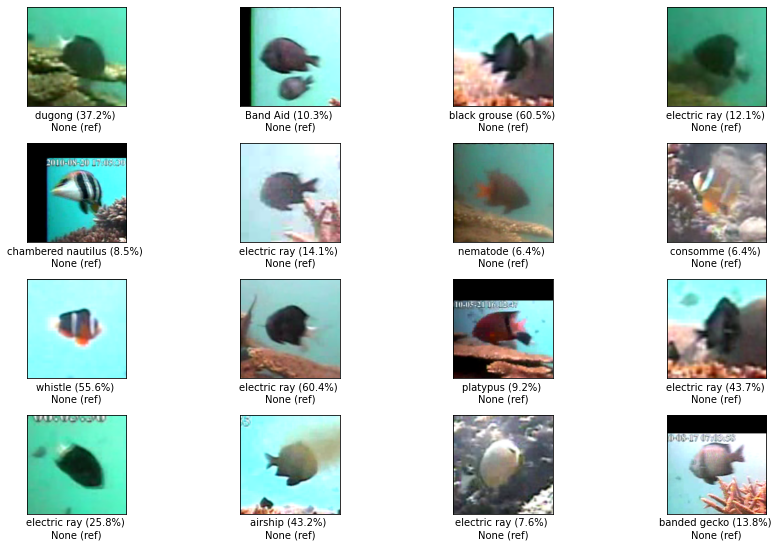

In [128]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, pin_memory=True, num_workers=2)

images, labels = next(iter(test_loader))
viz_image_batch(images, model, imagenet_classes, device=device)

## Exercise 18

Comment on the results.


Since the model has not been modified, it still outputs its prediction of the classes it has been trained on. The final layer of the model consists of 1000 nodes, which corresponds to the length of the imagenet_classes list. 

By replacing the final layer with a fully connected layer specific to our problem, the net can be adjusted for our application. 

## Exercise 19

We are now going to explore different settings of reusing the resnet-18 model. We will start with a non-pretrained model, by initialising the weights randomly and training all layers using the standard training loop that we did before.

To achieve this our first step is to **replace the output layer** in order to output logits for the correct number of classes (those found in our data).

We will first print the resnet model and identify the last layer.

Print a non-pretrained resnet18 model and identify the name of the output layer.

In [129]:

model_untrained = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
print(model_untrained)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


`fc` stands for Fully Connected, and it is the last layer in the model.

In order to replace it we must first remember it's input dimensionality, which can be obtained using `fc.in_features`.

## Exercise 20

Replace the `fc` layer of the vanilla resnet-18 by another `Linear` layer with as many outputs as classes in our fish dataset. Train the resulting model for 2 epochs and show the obtained accuracy.

In [130]:
print(model_untrained.fc.in_features)

512


In [131]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)


in_layers = model_untrained.fc.in_features
out_categories = len(full_set.classes)
fine_tuned_layer = nn.Linear(in_layers, out_categories)
model.fc = fine_tuned_layer


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Current loss at iteration 0: 3.3122854232788086
Current loss at iteration 50: 1.1375634670257568
Current loss at iteration 100: 1.1815217733383179
Current loss at iteration 150: 0.8086596131324768
Current loss at iteration 200: 0.8339368104934692
Current loss at iteration 250: 0.7533450722694397
Current loss at iteration 300: 0.7026612758636475
Current loss at iteration 0: 0.8314430713653564
Current loss at iteration 50: 0.42698803544044495
Current loss at iteration 100: 0.7619622349739075
Current loss at iteration 150: 0.39321643114089966
Current loss at iteration 200: 0.5554383397102356
Current loss at iteration 250: 0.38941147923469543
Current loss at iteration 300: 0.5125749111175537
Accuracy of the network on the test images: 88.1%


## Exercise 21

We will now try to leverage the large amount of natural imaging data from ImageNet, by using as backbone a pretrained resnet18 as starting point for training.


In [132]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)


in_layers = model_untrained.fc.in_features
out_categories = len(full_set.classes)
fine_tuned_layer = nn.Linear(in_layers, out_categories)
model.fc = fine_tuned_layer


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=1, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Current loss at iteration 0: 3.5920872688293457
Current loss at iteration 50: 0.4587377905845642
Current loss at iteration 100: 0.5192930698394775
Current loss at iteration 150: 0.18618299067020416
Current loss at iteration 200: 0.37388351559638977
Current loss at iteration 250: 0.19755813479423523
Current loss at iteration 300: 0.1815260797739029
Accuracy of the network on the test images: 96.5%


## Exercise 22
In some situations it may be faster and better in terms of achieved accuracy, to only train the last layer, while letting all other layers with their pretrained weights. To freeze a layer you may simply set the `require_grad` attribute of its parameters to `False`.

Sometimes it is still beneficial to perform an additional training phase in which all weights are updated for a couple of epochs. This is known as **fine tuning**. In this exercise we will only be training the inserted layer.

Implement this method and visualize the results on the first batch of test.

**Note**: You may iterate over all parameters of a model calling its `.parameters()` method.

**Note**: Make sure to not freeze the latest layer that you added.


In [133]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
    

length_layers = len(list(model.parameters()))
for i, param in enumerate(model.parameters()):
    if i == length_layers - 1:
        # Not freezing the final layer
        break
    param.requires_grad = False

in_layers = model_untrained.fc.in_features # dependent on parameters of the final layer
out_categories = len(full_set.classes)
fine_tuned_layer = nn.Linear(in_layers, out_categories)
model.fc = fine_tuned_layer # replacing the final layer 


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Current loss at iteration 0: 3.451674222946167
Current loss at iteration 50: 0.9306975603103638
Current loss at iteration 100: 1.079921007156372
Current loss at iteration 150: 0.7061819434165955
Current loss at iteration 200: 0.7793963551521301
Current loss at iteration 250: 0.6488831043243408
Current loss at iteration 300: 0.7052931785583496
Current loss at iteration 0: 0.8240165114402771
Current loss at iteration 50: 0.4152265787124634
Current loss at iteration 100: 0.6766365766525269
Current loss at iteration 150: 0.44779908657073975
Current loss at iteration 200: 0.576659083366394
Current loss at iteration 250: 0.476642906665802
Current loss at iteration 300: 0.5240697264671326
Accuracy of the network on the test images: 89.2%


## Exercise 23

Visualize the first batch of 16 images and it's predicted class in test.

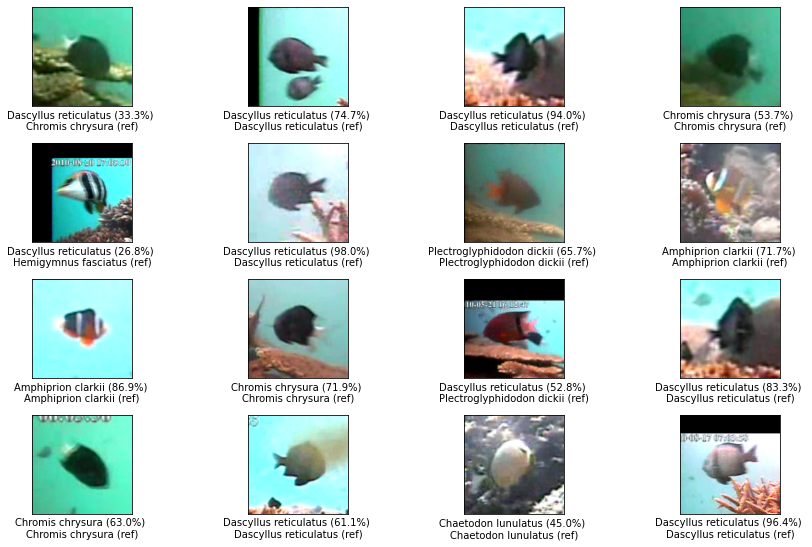

In [134]:

batch_size = 16
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

images, labels = next(iter(test_loader))
probs, preds = viz_image_batch(images, model, full_set.classes, labels=labels, device=device)


## (optional) Exercise 24

Try with one (or all) of the following backbones: [`AlexNet`](https://pytorch.org/hub/pytorch_vision_alexnet/), [`VGG`](https://pytorch.org/hub/pytorch_vision_vgg/), [`MobileNetV2`](https://pytorch.org/hub/pytorch_vision_mobilenet_v2/)

In [135]:
# All the models are used as backbones -> their params do not change during training
model_alex = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model_vgg11 = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=True)
model_mobilenet = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

models_backbones = {'alex': model_alex, 'vgg11': model_vgg11, 'mobilnet': model_mobilenet}

# Replacing the final layer for fine-tuning
for model_name, model in models_backbones.items():
    print("Freezing the gradients of the backbones...")
    length_layers = len(list(model.parameters()))
    for i, param in enumerate(model.parameters()):
        if i == length_layers - 1:
            # Not freezing the final layer
            break
        param.requires_grad = False

    print(f"Changing final layer of {model_name}...")
    in_layers = model.classifier[-1].in_features
    out_categories = len(full_set.classes)
    fine_tuned_layer = nn.Linear(in_layers, out_categories)
    model.classifier[-1] = fine_tuned_layer
    print(f"Changed final layer of {model_name}.")

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

    # Training of the backbones
    print(f"Currently training {model_name}...")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    batch_size = 64
    train_model(model, train_loader, optimizer, criterion, n_epochs=1, device=device, log_every=50)
    accuracy = evaluate_model(model, test_loader, device=device)
    print(f'Accuracy of the model: {model_name} on the test images: {accuracy:.1%} \n')


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Freezing the gradients of the backbones...
Changing final layer of alex...
Changed final layer of alex.
Currently training alex...


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Current loss at iteration 0: 3.0869059562683105
Current loss at iteration 50: 0.4381544888019562
Current loss at iteration 100: 0.8905892968177795
Current loss at iteration 150: 0.2831836938858032
Current loss at iteration 200: 0.4067569077014923
Current loss at iteration 250: 0.6669790148735046
Current loss at iteration 300: 0.4953364133834839
Current loss at iteration 350: 0.30661407113075256
Current loss at iteration 400: 0.8783746361732483
Current loss at iteration 450: 0.4415775537490845
Current loss at iteration 500: 0.5390244722366333
Current loss at iteration 550: 0.18585672974586487
Current loss at iteration 600: 0.34793248772621155
Current loss at iteration 650: 0.20812396705150604
Current loss at iteration 700: 0.14442749321460724
Current loss at iteration 750: 0.06143592670559883
Current loss at iteration 800: 0.5060759782791138
Current loss at iteration 850: 0.9214744567871094
Current loss at iteration 900: 0.3425998389720917
Current loss at iteration 950: 1.07599425315856

Visualising the performance of model with alex backbone on the test set...
Visualising the performance of model with vgg11 backbone on the test set...
Visualising the performance of model with mobilnet backbone on the test set...


<Figure size 432x288 with 0 Axes>

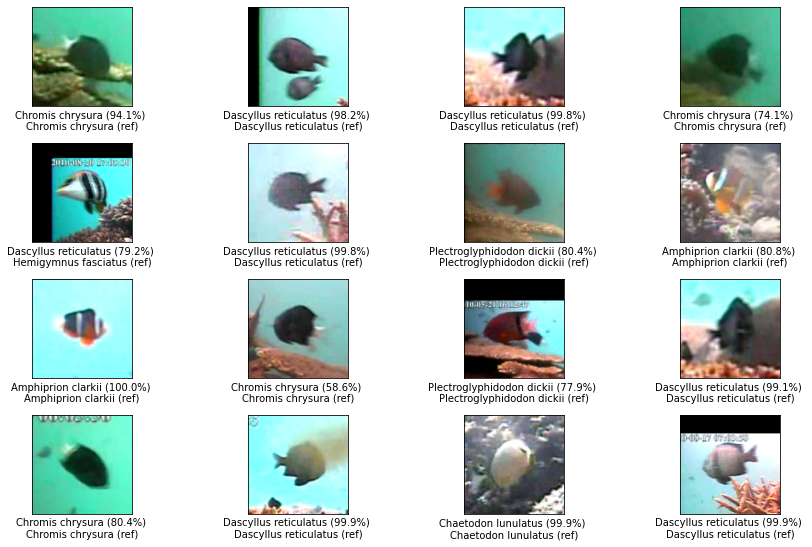

<Figure size 432x288 with 0 Axes>

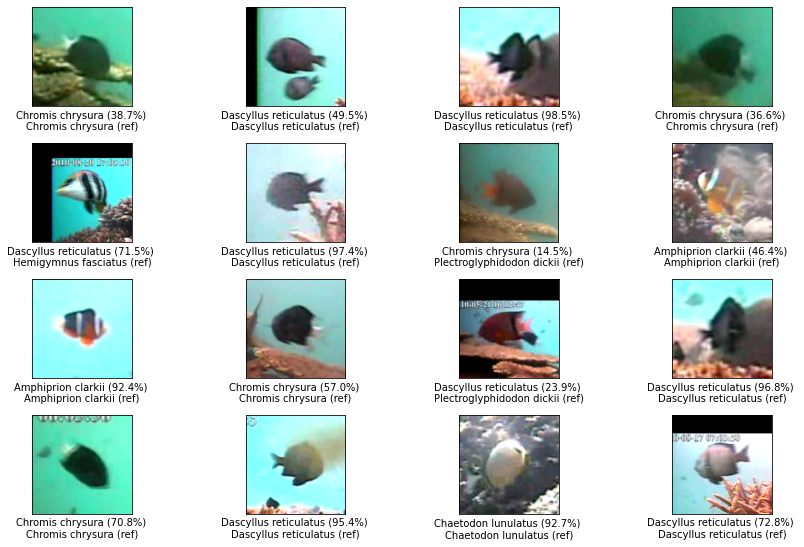

<Figure size 432x288 with 0 Axes>

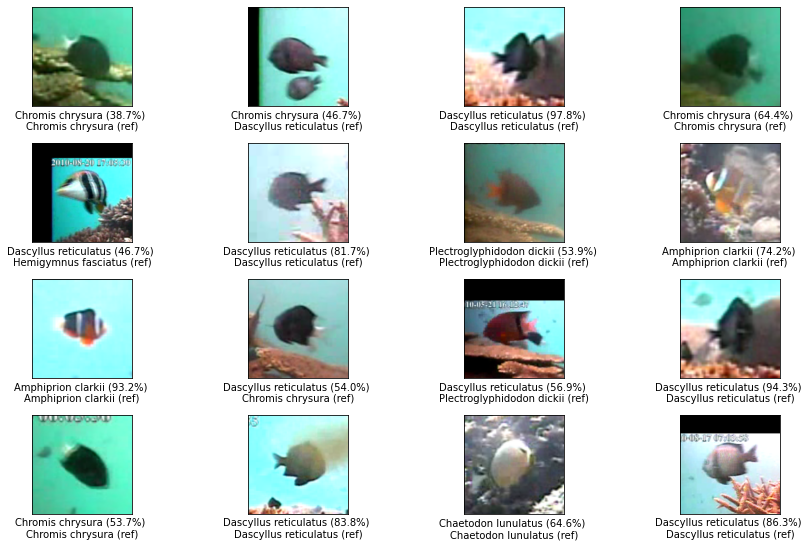

In [136]:
# Loading the top 16 images from the test set
batch_size = 16
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)
images, labels = next(iter(test_loader))

# Visualising the initial fish classes guessed by various backbones 
for model_name, model in models_backbones.items():
    fig = plt.figure()
    print(f"Visualising the performance of model with {model_name} backbone on the test set...")
    probs, preds = viz_image_batch(images, model, full_set.classes, labels=labels, device=device)

## (optional) Exercise 25

Perform fine tuning on one (or more) of the models we have done.

In [137]:
# Here we fine tune the entire model:
# all of the parameters are allowed to be modified during the backwards step
model_alex = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model_vgg11 = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=True)
model_mobilenet = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

models = {'alex': model_alex, 'vgg11': model_vgg11, 'mobilnet': model_mobilenet}

# Replacing the final layer for fine-tuning
for model_name, model in models.items():
    print(f"Changing final layer of {model_name}...")
    in_layers = model.classifier[-1].in_features
    out_categories = len(full_set.classes)
    fine_tuned_layer = nn.Linear(in_layers, out_categories)
    model.classifier[-1] = fine_tuned_layer
    print(f"Changed final layer of {model_name}.")

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

    # Training of the backbones
    print(f"Currently training {model_name}...")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    batch_size = 64
    train_model(model, train_loader, optimizer, criterion, n_epochs=1, device=device, log_every=50)
    accuracy = evaluate_model(model, test_loader, device=device)
    print(f'Accuracy of the model: {model_name} on the test images: {accuracy:.1%} \n')


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Changing final layer of alex...
Changed final layer of alex.
Currently training alex...


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Current loss at iteration 0: 2.823350429534912
Current loss at iteration 50: 0.67014479637146
Current loss at iteration 100: 0.8329893946647644
Current loss at iteration 150: 0.08987414836883545
Current loss at iteration 200: 0.17230364680290222
Current loss at iteration 250: 0.17460618913173676
Current loss at iteration 300: 0.2914414703845978
Current loss at iteration 350: 0.09865480661392212
Current loss at iteration 400: 0.46773287653923035
Current loss at iteration 450: 0.29030635952949524
Current loss at iteration 500: 0.489421546459198
Current loss at iteration 550: 0.020465493202209473
Current loss at iteration 600: 0.027044763788580894
Current loss at iteration 650: 0.025380535051226616
Current loss at iteration 700: 0.040890730917453766
Current loss at iteration 750: 0.02850276604294777
Current loss at iteration 800: 0.04396366700530052
Current loss at iteration 850: 0.159337118268013
Current loss at iteration 900: 0.015782751142978668
Current loss at iteration 950: 1.3681523

Visualising the performance of alex on the test set...
Visualising the performance of vgg11 on the test set...
Visualising the performance of mobilnet on the test set...


<Figure size 432x288 with 0 Axes>

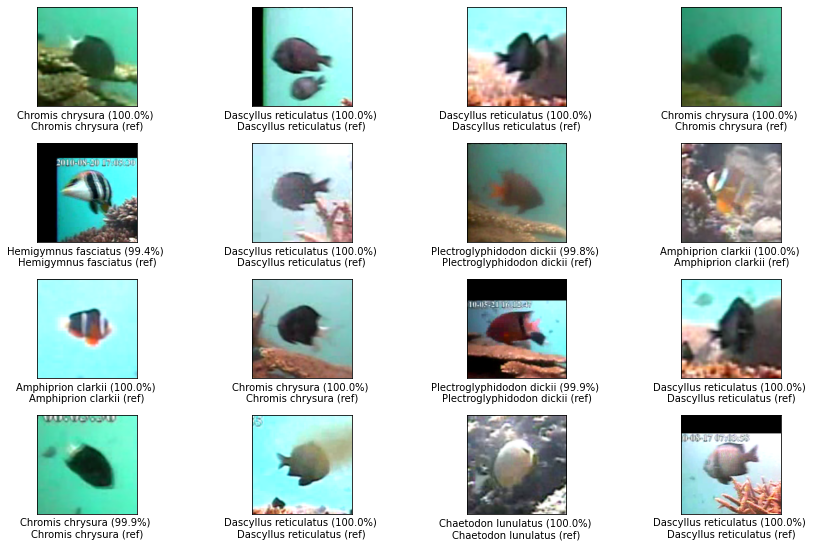

<Figure size 432x288 with 0 Axes>

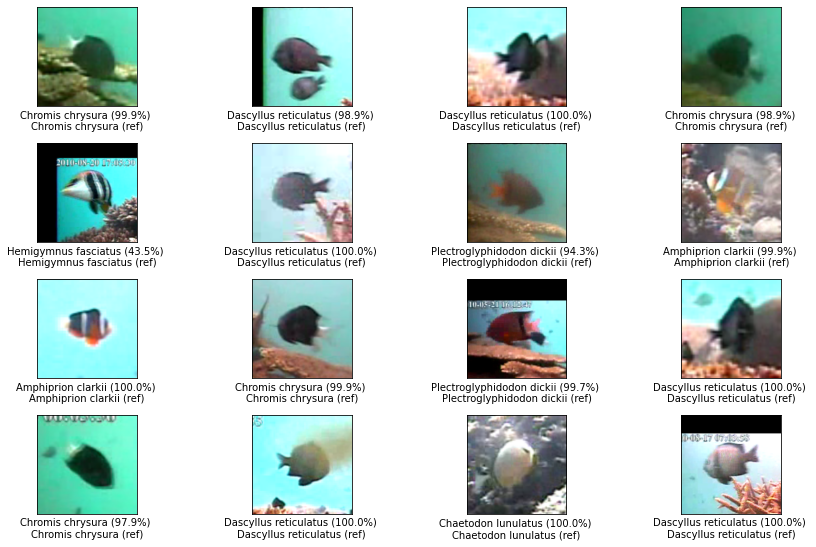

<Figure size 432x288 with 0 Axes>

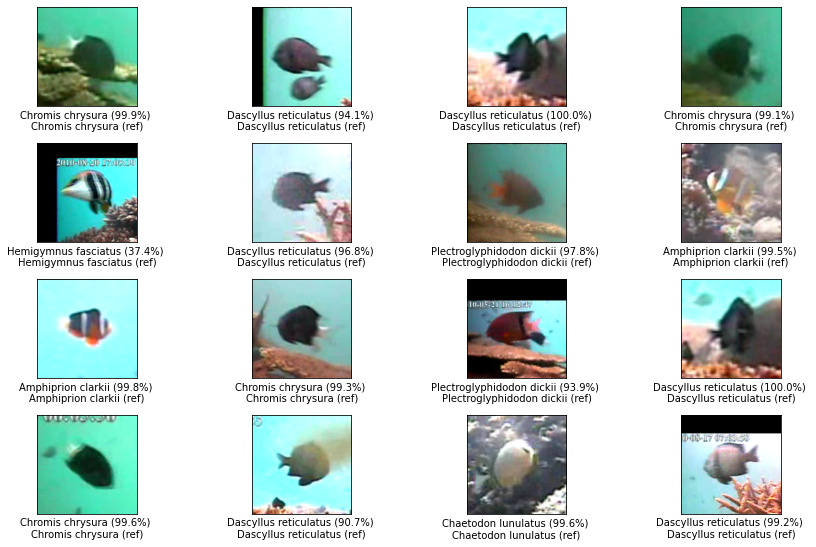

In [138]:
# Loading the top 16 images from the test set
batch_size = 16
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)
images, labels = next(iter(test_loader))

# Visualising the initial fish classes guessed by various backbones 
for model_name, model in models.items():
    plt.figure()
    print(f"Visualising the performance of {model_name} on the test set...")
    probs, preds = viz_image_batch(images, model, full_set.classes, labels=labels, device=device)

